In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
class Unicycle:
    def __init__(self, x=None,max_linear_velocity=2, max_angular_velocity=np.pi/3):
        if x is None:
            x = np.zeros(3)
        self.x = x
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity 
    
    def f(self, u, x=None, dt=0.1, save_x=True):
        if x is None:
            x = self.x
            
        # clip controls
        u[0] = np.clip(u[0],-self.max_linear_velocity,self.max_linear_velocity)
        u[1] = np.clip(u[1],-self.max_angular_velocity,self.max_angular_velocity)
        
        
        x_prime = x.copy()
        x_prime[0] = x[0] + u[0]*np.cos(x[2])*dt
        x_prime[1] = x[1] + u[0]*np.sin(x[2])*dt
        x_prime[2] = x[2] + u[1]*dt
        
        if save_x:
            self.x = x_prime
        return x_prime
    
    def getA(self, u, x=None, dt=0.1):
        if x is None:
            x = self.x
            
        A = np.eye(3) 
        A[:,2] += np.array([-u[0]*np.sin(x[2])*dt,
                            u[0]*np.cos(x[2])*dt,
                            0])
        return A
        
    def getB(self, x=None, dt=0.1):
        if x is None:
            x = self.x
            
        B = np.zeros((3,2))
        B[0,0] = np.cos(x[2])*dt
        B[1,0] = np.sin(x[2])*dt
        B[2,1] = dt
        return B
        
    def plot(self, x=None, ax=None):
        if x is None:
            x = self.x
            
        if ax is None:
            ax = plt
            
        get_T = lambda x, y, theta: np.array([[np.cos(theta),-np.sin(theta), x], [np.sin(theta),np.cos(theta), y], [0,0,0]])

        def get_point(T, x,y):
            x,y,_ = T@(np.array([[x,y,1]]).T).reshape(-1)
            return x,y

        x,y,theta = x
        T = get_T(x,y,theta)    
        points = [(0.1,0),(0,-0.05),(0,0.05),(0.1,0)]
        points = [get_point(T,*p) for p in points]
        ax.plot([p[0] for p in points], [p[1] for p in points], color='red')


![](imgs/ilqr.png)

In [3]:
def lqr(A, B, T=100):
    V = np.zeros((3,3))
    Q = np.zeros((5,5))
    K = np.zeros((2,3))
    C = np.eye(5)
    F = [A, B]
    for t in range(T):
        
        Q = C + F.T@V@F      
        Q_xx = Q[:3,:3]
        Q_uu = Q[3:,3:]
        Q_ux = Q[3:,:3]
        Q_xu = Q[:3,3:]
        
        K = -np.linalg.inv(Q_uu)@Q_ux
        V = 
    return K

In [4]:
dt = 0.1
x = np.array([0.,0.,0.]) 
xf = np.array([2.000,2.000,np.pi/2])  

track = []
unicycle = Unicycle(x=x)
u = np.zeros(2)

for i in range(200):
    x = unicycle.x
    print(f'iteration = {i}')
    print(f'Current State = {x}')
    print(f'Desired State = {xf}')

    error = x - xf
    track.append(x)
    state_error_magnitude = np.linalg.norm(error)     
    print(f'State Error Magnitude = {state_error_magnitude}')

    B = unicycle.getB(x=x, dt=dt)
    A = unicycle.getA(np.zeros(2), x=x, dt=dt)
    
    K = lqr(A, B) 
    
    # u = ...
    u = K@x
    
    print(f'Control Input = {u}')

    x=unicycle.f(u, x=x, dt=dt)  
    
    if state_error_magnitude < 0.05:
        print(f"\nGoal Has Been Reached Successfully in {i} iterations!")
        break

    print()

iteration = 0
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 1
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 2
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 3
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 4
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 5
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 6
Current State = [0. 0. 0.]

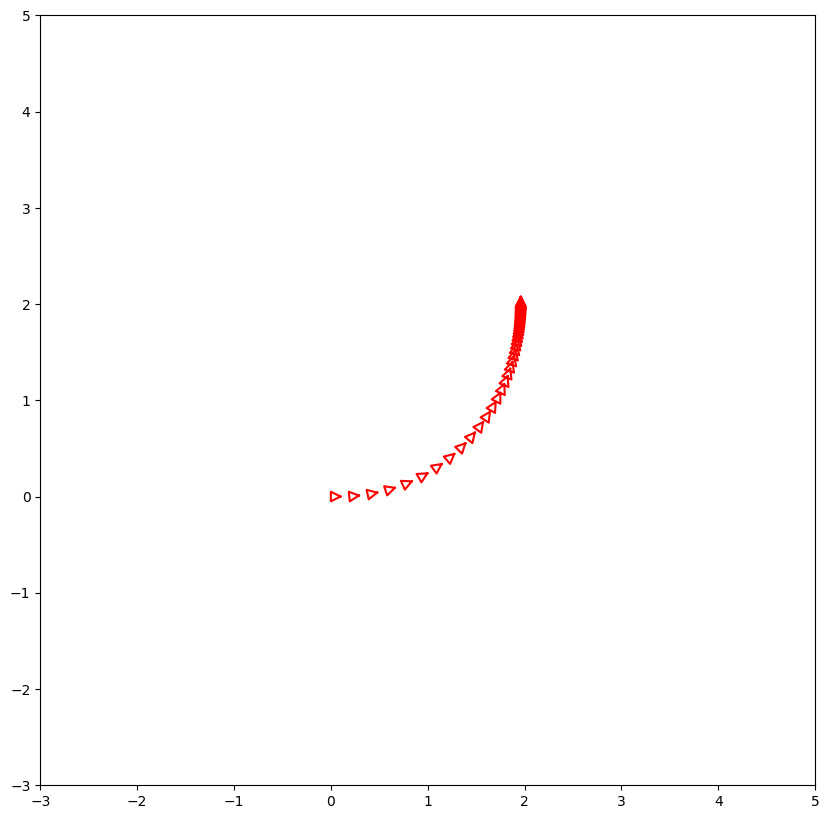

In [19]:
plt.subplots(figsize=(10,10))
plt.xlim(-3,5)
plt.ylim(-3,5)
for x in track:
    unicycle.plot(x)
plt.show()

In [3]:
def lqr_rob(A, B, T=300):
    Q = np.eye(3)
    R = np.eye(2)
    P = np.zeros((3,3))
    for t in range(T):  # ps: don't use t, just run T times
        K = np.zeros((2,3))
        K = -np.linalg.inv(R+B.T@P@B)@B.T@P@A
        P = (Q + K.T@R@K+(A+B@K).T@P@(A+B@K))
    return K, P

In [7]:
dt = 0.1
x = np.array([0.,0.,0.]) 
xf = np.array([2.000,1.5, np.pi/4])  

track = []
unicycle = Unicycle(x=x)
u = np.zeros(2)

for i in range(200):
    x = unicycle.x
    print(f'iteration = {i}')
    print(f'Current State = {x}')
    print(f'Desired State = {xf}')

    error = x - xf
    track.append(x)
    state_error_magnitude = np.linalg.norm(error)     
    print(f'State Error Magnitude = {state_error_magnitude}')

    B = unicycle.getB(x=x, dt=dt)
    A = unicycle.getA(np.zeros(2), x=x, dt=dt)
    
    K, P = lqr_rob(A, B) 
    print(f'K: {K}')
    print(f'P: {P}')

    u = K@error
    
    print(f'Control Input = {u}')

    x=unicycle.f(u, x=x, dt=dt)  
    
    if state_error_magnitude < 0.05:
        print(f"\nGoal Has Been Reached Successfully in {i} iterations!")
        break

    print()

iteration = 0
Current State = [0. 0. 0.]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 2.620467568024471
K: [[-0.95124922  0.          0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 10.5124922   0.          0.       ]
 [  0.        300.          0.       ]
 [  0.          0.         10.5124922]]
Control Input = [1.90249844 0.74710939]

iteration = 1
Current State = [0.19024984 0.         0.07471094]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 2.4556612059174308
K: [[-0.94859565 -0.07100263  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 12.12532753 -21.54749275   0.        ]
 [-21.54749275 298.38716467   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [1.82322506 0.67604067]

iteration = 2
Current State = [0.37206375 0.01360882 0.14231501]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 2.2963212166284963
K: [[-0.94163238 -0.13492052  0.        ]
 [ 0.    

P: [[ 141.43525781 -144.08238815    0.        ]
 [-144.08238815  169.07723439    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.21928667 0.04548474]

iteration = 29
Current State = [2.24396825 0.92132937 0.74213084]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.6294857174241775
K: [[-0.70109929 -0.64291124  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 142.74652171 -144.20215355    0.        ]
 [-144.20215355  167.76597049    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.20098789 0.04115801]

iteration = 30
Current State = [2.25878166 0.93491333 0.74624664]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.6227549518582925
K: [[-0.69844727 -0.64579137  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 143.93394689 -144.30024198    0.        ]
 [-144.30024198  166.5785453     0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [

K: [[-0.67479522 -0.67046736  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 154.32494267 -144.7407578     0.        ]
 [-144.7407578   156.18754953    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.01986008 0.00306026]

iteration = 56
Current State = [2.40019201 1.07042123 0.78248709]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5871116067614528
K: [[-0.67459001 -0.67067384  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 154.41353178 -144.74130069    0.        ]
 [-144.74130069  156.09896042    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.01814171 0.00276916]

iteration = 57
Current State = [2.40147855 1.0717003  0.78276401]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5870541684060009
K: [[-0.67440426 -0.67086062  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 154.49369414 -144.74174522    0.        ]
 [-144.74174522  156.01879

K: [[-0.67275397 -0.67251555  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.20494055 -144.74374481    0.        ]
 [-144.74374481  155.30755165    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.00139567 0.00016859]

iteration = 85
Current State = [2.41389449 1.0840809  0.78523779]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867685826355918
K: [[-0.67274264 -0.67252689  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.20982098 -144.74374646    0.        ]
 [-144.74374646  155.30267122    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.00127231 0.00015255]

iteration = 86
Current State = [2.41398447 1.08417085 0.78525305]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867683024392866
K: [[-0.67273238 -0.67253716  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.21423717 -144.74374781    0.        ]
 [-144.74374781  155.29825

K: [[-0.67264015 -0.6726294   0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25393184 -144.74375388    0.        ]
 [-144.74375388  155.25856036    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [7.74962947e-05 7.60459885e-06]

iteration = 116
Current State = [2.41485143 1.08503768 0.78539093]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669356249393
K: [[-0.67263964 -0.67262991  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25415198 -144.74375389    0.        ]
 [-144.74375389  155.25834021    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [7.05489252e-05 6.88121198e-06]

iteration = 117
Current State = [2.41485642 1.08504267 0.78539162]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669347675668
K: [[-0.67263918 -0.67263037  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25435119 -144.74375389    0.        ]
 [-144.7

K: [[-0.67263517 -0.67263437  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25607402 -144.7437539     0.        ]
 [-144.7437539   155.25641817    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [6.6689878e-06 5.6543230e-07]

iteration = 142
Current State = [2.41490214 1.08508839 0.78539763]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669306673559
K: [[-0.67263514 -0.67263441  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25609039 -144.7437539     0.        ]
 [-144.7437539   155.2564018     0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [6.06616112e-06 5.11645597e-07]

iteration = 143
Current State = [2.41490257 1.08508882 0.78539768]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669306610319
K: [[-0.6726351  -0.67263445  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.2561052  -144.7437539     0.        ]
 [-144.743

K: [[-0.67263481 -0.67263474  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25623047 -144.7437539     0.        ]
 [-144.7437539   155.25626172    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [6.81614955e-07 5.13461240e-08]

iteration = 166
Current State = [2.41490639 1.08509264 0.78539811]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669306311633
K: [[-0.67263481 -0.67263474  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25623196 -144.7437539     0.        ]
 [-144.7437539   155.25626024    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [6.19642328e-07 4.64618279e-08]

iteration = 167
Current State = [2.41490644 1.08509269 0.78539812]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669306310973
K: [[-0.6726348  -0.67263474  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.2562333  -144.7437539     0.        ]
 [-144.7

K: [[-0.67263478 -0.67263477  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25624524 -144.7437539     0.        ]
 [-144.7437539   155.25624696    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [4.26099037e-08 2.82864115e-09]

iteration = 195
Current State = [2.41490685 1.08509309 0.78539816]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669306307858
K: [[-0.67263478 -0.67263477  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25624532 -144.7437539     0.        ]
 [-144.7437539   155.25624688    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [3.87145231e-08 2.55956693e-09]

iteration = 196
Current State = [2.41490685 1.0850931  0.78539816]
Desired State = [2.         1.5        0.78539816]
State Error Magnitude = 0.5867669306307854
K: [[-0.67263478 -0.67263477  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 155.25624539 -144.7437539     0.        ]
 [-144.7

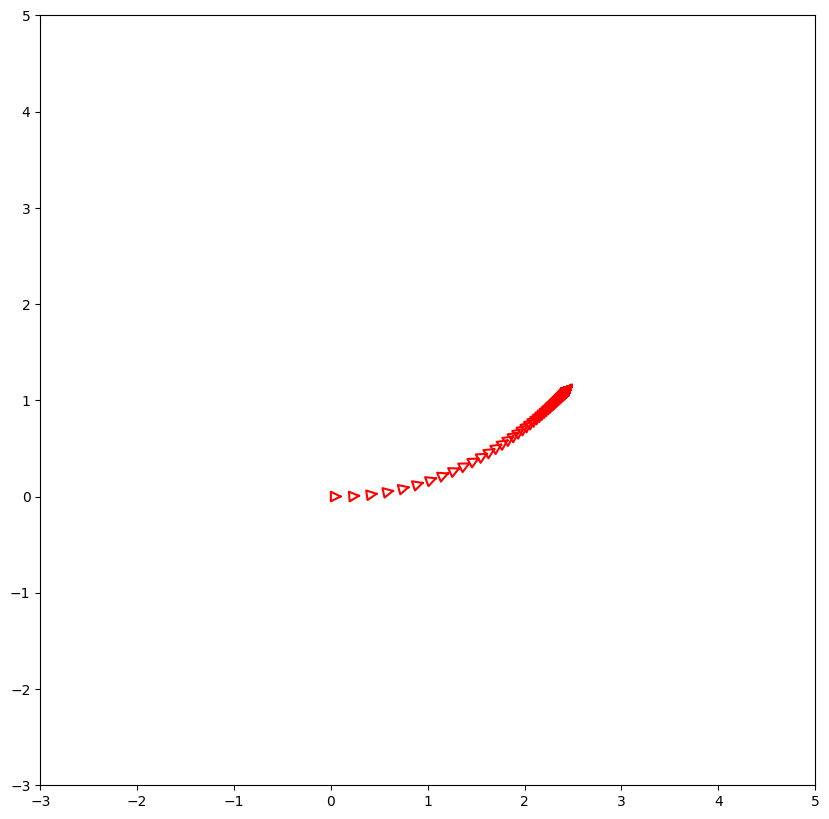

In [8]:
plt.subplots(figsize=(10,10))
plt.xlim(-3,5)
plt.ylim(-3,5)
for x in track:
    unicycle.plot(x)
plt.show()